In [ ]:
!pip install snntorch brevitas tonic --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.4/411.4 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.7/109.7 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 6.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# @title Dataset
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import csv
import itertools
import collections

import pywt
from scipy import stats

# from utils import denoise

plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True




class Dataset:
    def __init__(self):
        self.dataset = None
        self.data_path = None


    def denoise(data):
        w = pywt.Wavelet('sym4')
        maxlev = pywt.dwt_max_level(len(data), w.dec_len)
        threshold = 0.04 # Threshold for filtering

        coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
        for i in range(1, len(coeffs)):
            coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))

        datarec = pywt.waverec(coeffs, 'sym4')

        return datarec

    def load_dataset(self, data_path):

        print("Loading dataset from: ", data_path)

        records = list()
        annotations = list()

        for file in os.listdir(data_path):
            if file.endswith(".csv"):
                records.append(data_path+file)
            elif file.endswith(".txt"):
                annotations.append(data_path+file)

        records.sort()
        annotations.sort()

        # print(records[0], annotations[0])

        return records, annotations




    def preprocess(self,records,annotations):
        maximum_counting = 10000
        window_size = 180
        classes = ['N', 'L', 'R', 'A', 'V']
        n_classes = 5
        count_classes = [0]*5
        X = list()
        y = list()
        for r in range(0,len(records)):
            signals = []

            with open(records[r], 'rt') as csvfile:
                spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
                row_index = -1
                for row in spamreader:
                    if(row_index >= 0):
                        signals.insert(row_index, int(row[1]))
                    row_index += 1

            # # Plot an example to the signals
            if r == 6:
                # Plot each patient's signal
                plt.title(records[6] + " Wave")
                plt.plot(signals[0:700])
                plt.show()
            def denoise(data):
                w = pywt.Wavelet('sym4')
                maxlev = pywt.dwt_max_level(len(data), w.dec_len)
                threshold = 0.04 # Threshold for filtering

                coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
                for i in range(1, len(coeffs)):
                    coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))

                datarec = pywt.waverec(coeffs, 'sym4')

                return datarec
            signals = denoise(signals)
            # # Plot an example to the signals
            if r == 6:
                # Plot each patient's signal
                plt.title(records[6] + " wave after denoised")
                plt.plot(signals[0:700])
                plt.show()

            # signals = stats.zscore(signals)
            # # Plot an example to the signals
            # if r == 6:
            #     # Plot each patient's signal
            #     plt.title(records[6] + " wave after z-score normalization ")
            #     plt.plot(signals[0:700])
            #     plt.show()

            # Read anotations: R position and Arrhythmia class
            example_beat_printed = False
            with open(annotations[r], 'r') as fileID:
                data = fileID.readlines()
                beat = list()

                for d in range(1, len(data)): # 0 index is Chart Head
                        splitted = data[d].split(' ')
                        splitted = filter(None, splitted)
                        next(splitted) # Time... Clipping
                        pos = int(next(splitted)) # Sample ID
                        arrhythmia_type = next(splitted) # Type
                        if(arrhythmia_type in classes):
                            arrhythmia_index = classes.index(arrhythmia_type)
                    # if count_classes[arrhythmia_index] > maximum_counting: # avoid overfitting
                            #    pass
                        #else:
                            count_classes[arrhythmia_index] += 1
                            if(window_size <= pos and pos < (len(signals) - window_size)):
                                beat = signals[pos-window_size:pos+window_size]     ## REPLACE WITH R-PEAK DETECTION
                                # # Plot an example to a beat
                                # if r == 6 and not example_beat_printed:
                                #     plt.title("A Beat from " + records[6] + " Wave")
                                #     plt.plot(beat)
                                #     plt.show()
                                #     example_beat_printed = True

                                X.append(beat)
                                y.append(arrhythmia_index)

        return X, y

In [ ]:
# @title plot_signals
import pywt
import matplotlib.pyplot as plt

# from dataset import Dataset

plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True


def plot_signals(signals, title):

    plt.title("ECG signal: " + title)
    plt.plot(signals)
    plt.show()

Loading dataset from:  /content/drive/MyDrive/dataset/


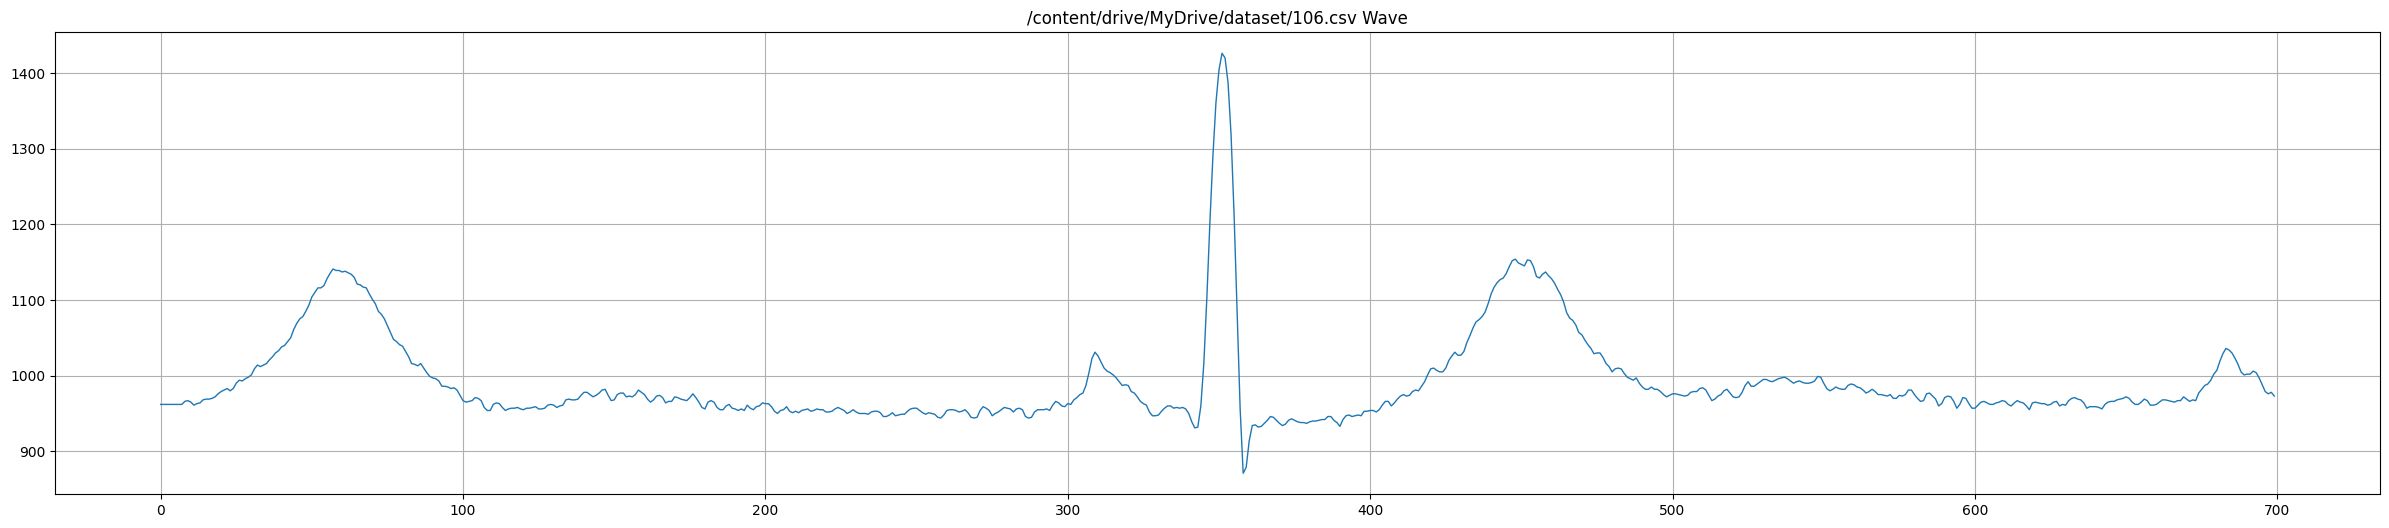

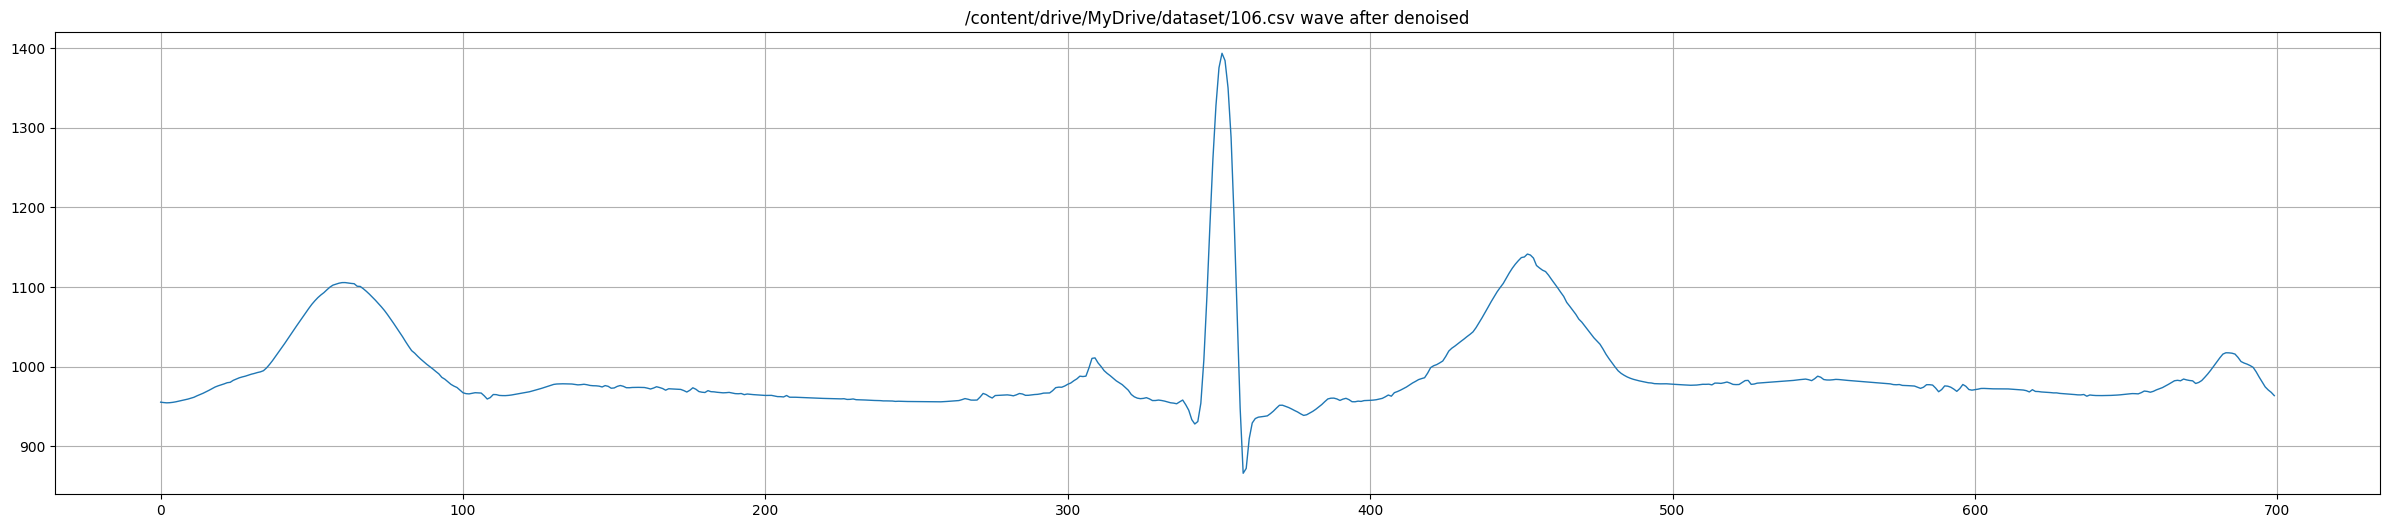

In [ ]:
dataset = Dataset()
data_path = '/content/drive/MyDrive/dataset/'

records, annotations = dataset.load_dataset(data_path)

X = []
y = []
X, y = dataset.preprocess(records, annotations)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import tonic

class CustomDataset(Dataset):
    def __init__(self, X, y,transform=None):
        self.data = torch.tensor(X, dtype=torch.float32)
        self.targets = torch.tensor(y, dtype=torch.long)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]


In [ ]:
from sklearn.model_selection import train_test_split

import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=104, train_size=0.8, shuffle=True)

In [ ]:
X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)

<ipython-input-8-ece976961388>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  X_train = torch.tensor(X_train)


In [ ]:
X_train.shape[0]

80009

In [ ]:
X_train[0][20:40]

tensor([844.3234, 843.0329, 844.0963, 846.3206, 848.9969, 852.2173, 855.6053,
        859.2246, 863.2994, 867.5763, 871.5012, 875.3930, 879.4109, 883.5234,
        887.8396, 892.3032, 896.8406, 901.4892, 906.3325, 911.2983],
       dtype=torch.float64)

In [ ]:
spikes_train = []
spikes_test = []

In [ ]:
from snntorch.spikegen import delta

for i in range(X_train.shape[0]):
    spikes_train.append(delta(X_train[i], threshold=.55, off_spike=True, padding=True))
    if i < X_test.shape[0]:
      spikes_test.append(delta(X_test[i], threshold=.55, off_spike=True, padding=True))

X_train_spikes = torch.stack(spikes_train, dim=0)
X_test_spikes = torch.stack(spikes_test, dim=0)


In [ ]:
X_train_spikes.shape

torch.Size([80009, 360])

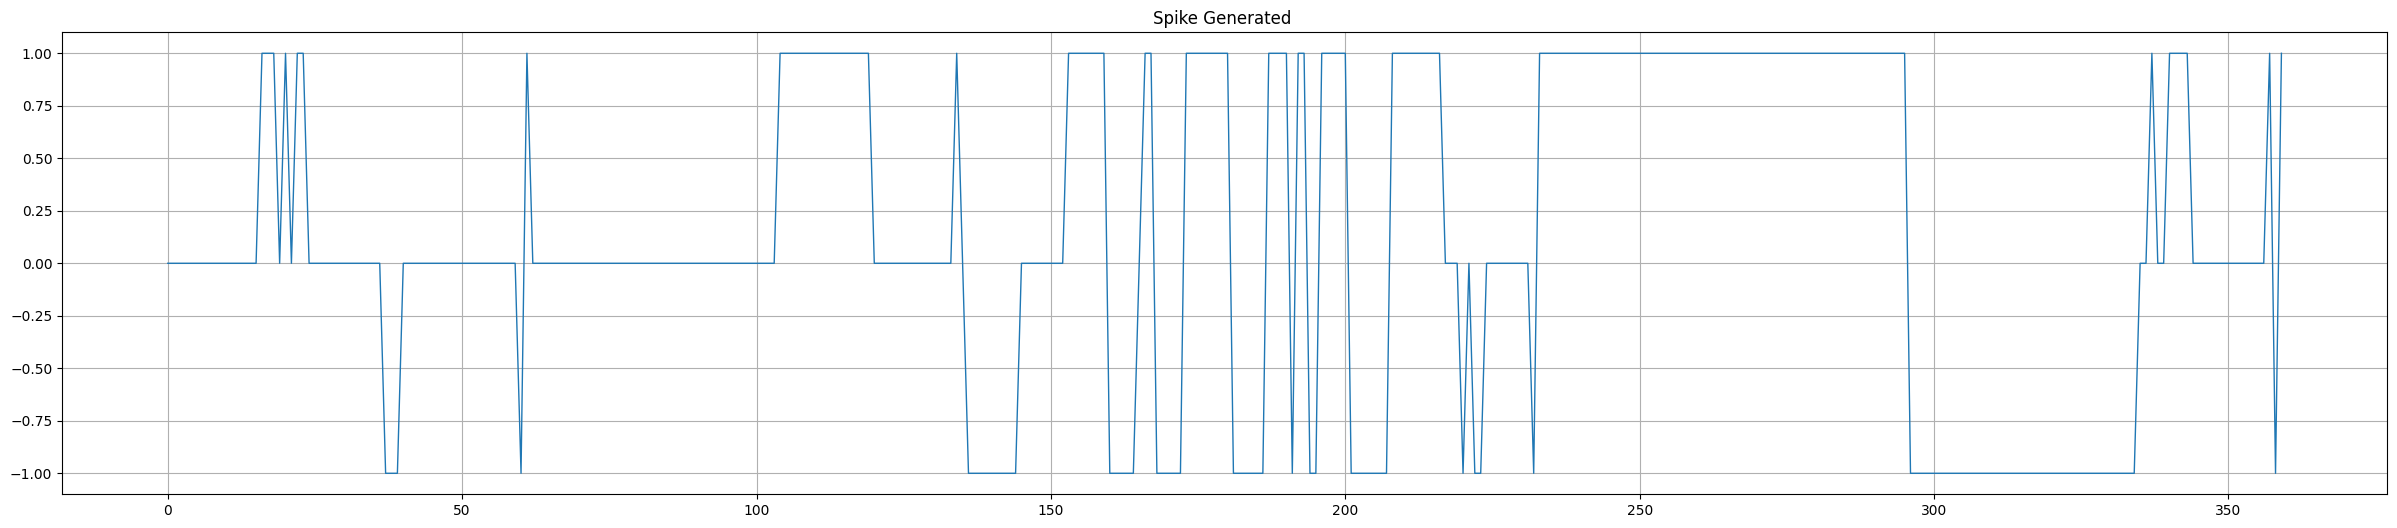

In [ ]:
plt.title("Spike Generated ")
plt.plot(X_train_spikes[999])
plt.show()

In [ ]:
train_dataset = CustomDataset(X_train_spikes, y_train)
test_dataset = CustomDataset(X_test_spikes, y_test)
batch_size = 128

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

<ipython-input-6-e792fc02e385>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(X, dtype=torch.float32)
<ipython-input-6-e792fc02e385>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.targets = torch.tensor(y, dtype=torch.long)


In [ ]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
import torch

# plotting
import matplotlib.pyplot as plt
from IPython.display import HTML

# import
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import itertools

In [ ]:
# Network Architecture
num_inputs = 360
num_hidden = 512
num_outputs = 5
population = 100

# Temporal Dynamics
num_steps = 1
beta1 = torch.randn(118)
beta3 = torch.randn(100)
beta4 = torch.randn(5)

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
from snntorch.spikegen import rate_conv
import brevitas.nn as qnn
from snntorch.functional import quant

# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        qlif = quant.state_quant(num_bits=3, uniform=False, thr_centered=True)

        self.conv1 = qnn.QuantConv1d(in_channels=1, out_channels=32, kernel_size=5, bias=False,  weight_bit_width=3)
        self.lif1 = snn.Leaky(beta=beta1, learn_beta=True, learn_threshold=True, state_quant=qlif )
        self.pool1 = nn.MaxPool1d(kernel_size=3)
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        self.conv2 = qnn.QuantConv1d(in_channels=32, out_channels=64, kernel_size=5, bias=False,  weight_bit_width=3)
        self.conv_out_size = self.calculate_conv_output_size()
        self.lif2 = snn.Leaky(beta=torch.randn(self.conv_out_size), learn_beta=True, learn_threshold=True)


        self.fc1 = qnn.QuantLinear(64 * self.conv_out_size, 5, bias=False,  weight_bit_width=3)
        self.lif3 = snn.Leaky(beta=beta4, learn_beta=True, learn_threshold=True)

    def calculate_conv_output_size(self):
        # Calculate the output size after convolutions and pooling
        x = torch.randn(1, 1, 360)  # Example input
        x = self.pool1(self.conv1(x))
        x = self.pool2(self.conv2(x))
        return x.size(2)

    def forward(self, x):
        # x = rate_conv(x)
        x = x.unsqueeze(1)
        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        # Record the final layer
        spk4_rec = []
        mem4_rec = []


        cur1 = self.conv1(x)
        spk1, mem1 = self.lif1(self.pool1(cur1), mem1)
        cur2 = self.conv2(spk1)
        spk2, mem2 = self.lif2(self.pool2(cur2), mem2)
        cur3 = self.fc1(spk2.flatten(1))
        spk3, mem3 = self.lif3(cur3, mem3)

        spk4_rec.append(spk3)
        mem4_rec.append(mem3)

        return torch.stack(spk4_rec, dim=0), torch.stack(mem4_rec, dim=0) # time-steps x batch x num_out

# Load the network onto CUDA if available
net = Net().to(device)

In [ ]:
def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data)
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer():
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

In [ ]:
num_epochs = 5
loss_hist = []
test_loss_hist = []
counter = 0

import snntorch.functional as SF

# loss = SF.ce_max_membrane_loss()

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))


# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()

        spk_rec, mem_rec = net(data)

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer()
            counter += 1
            iter_counter +=1

Epoch 0, Iteration 0
Train Set Loss: 1.61
Test Set Loss: 1.61
Train set accuracy for a single minibatch: 78.12%
Test set accuracy for a single minibatch: 75.00%


Epoch 0, Iteration 50
Train Set Loss: 1.58
Test Set Loss: 1.57
Train set accuracy for a single minibatch: 78.91%
Test set accuracy for a single minibatch: 76.56%


Epoch 0, Iteration 100
Train Set Loss: 0.59
Test Set Loss: 0.57
Train set accuracy for a single minibatch: 71.88%
Test set accuracy for a single minibatch: 76.56%


Epoch 0, Iteration 150
Train Set Loss: 0.41
Test Set Loss: 0.31
Train set accuracy for a single minibatch: 81.25%
Test set accuracy for a single minibatch: 86.72%


Epoch 0, Iteration 200
Train Set Loss: 0.35
Test Set Loss: 0.30
Train set accuracy for a single minibatch: 82.03%
Test set accuracy for a single minibatch: 78.91%


Epoch 0, Iteration 250
Train Set Loss: 0.16
Test Set Loss: 0.31
Train set accuracy for a single minibatch: 85.94%
Test set accuracy for a single minibatch: 82.81%


Epoch 0, Iter

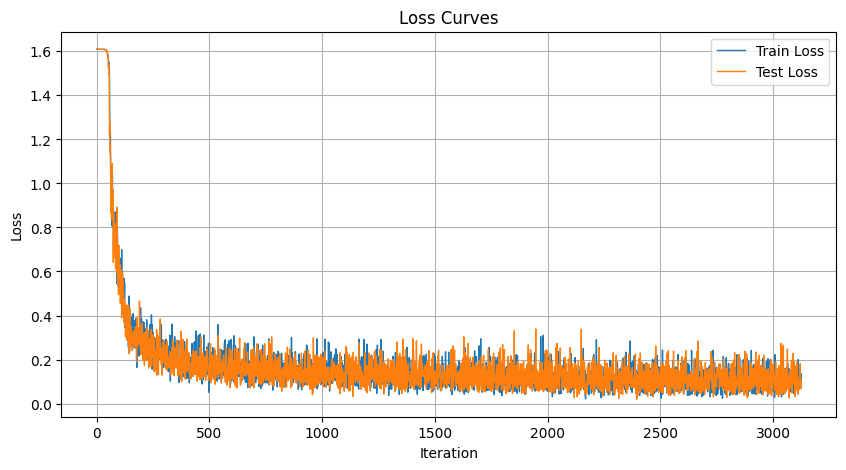

In [ ]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [ ]:
torch.save(net.state_dict(), "convnet.pt")

In [ ]:
# trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
# all parameters
def all_parameters(model):
    return sum(p.numel() for p in model.parameters())

In [ ]:
print(f"Number of trainable parameters: {count_parameters(net)}")
print(f"Total number of parameters: {all_parameters(net)}")

Number of trainable parameters: 28823
Total number of parameters: 28823


In [ ]:
print("Model's state_dict:")
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())

Model's state_dict:
conv1.weight 	 torch.Size([32, 1, 5])
lif1.threshold 	 torch.Size([])
lif1.beta 	 torch.Size([118])
lif1.graded_spikes_factor 	 torch.Size([])
lif1.reset_mechanism_val 	 torch.Size([])
conv2.weight 	 torch.Size([64, 32, 5])
lif2.threshold 	 torch.Size([])
lif2.beta 	 torch.Size([57])
lif2.graded_spikes_factor 	 torch.Size([])
lif2.reset_mechanism_val 	 torch.Size([])
fc1.weight 	 torch.Size([5, 3648])
lif3.threshold 	 torch.Size([])
lif3.beta 	 torch.Size([5])
lif3.graded_spikes_factor 	 torch.Size([])
lif3.reset_mechanism_val 	 torch.Size([])


In [ ]:
total = 0
correct = 0
flag = True
with torch.no_grad():
  net.eval()
  for data, targets in test_loader:
    data = data.to(device)
    targets = targets.to(device)

    # forward pass
    test_spk, test_mem = net(data.view(data.size(0), -1))

    if flag == True:
      x = data
      mem_rec = test_mem[0]
      spk_rec = test_spk[0]

    # calculate total accuracy
    _, predicted = test_spk.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

In [ ]:
print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set images: 18676/19968
Test Set Accuracy: 93.53%
